# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---


#### Step 1: Data Pre-processing and Management
1. **Dataset Preparation**:
   - Work with provided uncompressed `.wav` files, which may contain large portions without any seal calls.
   - Create a dataset from annotated data using the provided Jupyter notebook.
   
2. **Spectrogram Extraction**:
   - Extract spectrograms for each seal call, ensuring consistent size by determining the longest call (in time) and the broadest in frequency.
   - Save spectrograms as raw 2D arrays (not images) with metadata.

3. **Handling No-Call Data**:
   - Create "no-call" spectrograms from unannotated regions of recordings, ensuring they match the frequency region of call spectrograms.

In [2]:
# Imports

import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
# Global variables

FMIN = 20
FMAX = 1000
NFFT = 4096
NPERSEG = 2456
NOVERLAP = 1228
WINDOW = 'hann'

In [8]:
folders = ['Guttural rupe', 'Moan', 'Rupes A and B']

Funcion to read all text files from a list of folders and organise their data into a DataFrame.

In [52]:
def read_text_files(folders: list) -> pd.DataFrame:
    data = []
    
    # Iterate through all folders
    for folder in folders:
        # Ensure the folder exists
        if not os.path.isdir(folder):
            print(f"Warning: {folder} is not a valid directory.")
            continue
        
        # Iterate through all files in the folder
        for filename in os.listdir(folder):
            if filename.endswith('.txt'):
                # Construct the file path
                file_path = os.path.join(folder, filename)
                try:
                    # Read the text file
                    df = pd.read_csv(file_path, sep='\t')

                    # Add metadata columns for file and folder names
                    df['file_name'] = os.path.splitext(filename)[0].replace('.Table.1.selections', '')
                    df['folder_name'] = os.path.basename(folder)
                    
                    # Append to the data list
                    data.append(df)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    # Combine all data into a single DataFrame
    combined_df = pd.concat(data, ignore_index=True) if data else pd.DataFrame()
    return combined_df

In [53]:
df1 = read_text_files(folders)

In [54]:
df1

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name
0,1,Spectrogram 1,1,5.889650,6.350837,132.979,465.426,0.4612,332.447,-91.28,G rupe,5711.211015190024,Guttural rupe
1,2,Spectrogram 1,1,27.573252,28.034439,132.979,259.309,0.4612,126.330,-89.02,G rupe,5711.211015190024,Guttural rupe
2,3,Spectrogram 1,1,44.029301,44.348935,146.277,445.479,0.3196,299.202,-98.10,G rupe,5711.211015190024,Guttural rupe
3,4,Spectrogram 1,1,44.458524,45.052132,159.574,452.128,0.5936,292.553,-98.04,G rupe,5711.211015190024,Guttural rupe
4,5,Spectrogram 1,1,53.929418,54.363208,119.681,438.830,0.4338,319.149,-91.23,G rupe,5711.211015190024,Guttural rupe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,20,Spectrogram 1,1,330.712676,331.059708,53.191,511.968,0.3470,458.777,-90.81,Rupe B,5713.210825190002,Rupes A and B
1697,21,Spectrogram 1,1,332.196691,332.513890,53.191,498.670,0.3172,445.479,-90.46,Rupe B,5713.210825190002,Rupes A and B
1698,22,Spectrogram 1,1,393.662691,393.754015,46.543,398.936,0.0913,352.393,-86.90,Rupe A,5713.210825190002,Rupes A and B
1699,23,Spectrogram 1,1,538.315565,538.411456,39.894,292.553,0.0959,252.659,-85.05,Rupe A,5713.210825190002,Rupes A and B


Funcion to read all WAV files from a list of folders and organise their data into a DataFrame.

In [9]:
def read_wav_files(folders: list) -> pd.DataFrame:
    data = []
    
    # Iterate through all folders
    for folder in folders:
        # Ensure the folder exists
        if not os.path.isdir(folder):
            print(f"Warning: {folder} is not a valid directory.")
            continue
        # Iterate through all files in the folder
        for filename in os.listdir(folder):
            if filename.endswith('.wav'):
                # Extract the base name and construct the WAV file path
                base_name = os.path.splitext(filename)[0]
                wav_file_path = os.path.join(folder, filename)
                try:
                    # Read the WAV file
                    sample_rate, samples = wavfile.read(wav_file_path)

                    # Append the results as a dictionary for each file
                    data.append({
                        "file_name": base_name,
                        "folder_name": os.path.basename(folder),
                        "sample_rate": sample_rate,
                        "samples": samples,
                    })
                except Exception as e:
                    print(f"Error reading {wav_file_path}: {e}")
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

In [10]:
df = read_wav_files(folders)

In [11]:
df

,file_name,folder_name,sample_rate,samples
0,5711.211015210024,Guttural rupe,96000,"[0, 2, -10, 59, 145, 132, 129, 126, 123, 120, ..."
1,5711.211015190024,Guttural rupe,96000,"[0, 2, -10, 59, 145, 132, 129, 126, 123, 120, ..."
2,5711.211015200024,Guttural rupe,96000,"[0, 1, -6, 36, 87, 74, 68, 62, 57, 52, 48, 44,..."
3,5711.211015090024,Guttural rupe,96000,"[0, 2, -10, 59, 145, 132, 129, 126, 123, 120, ..."
4,5711.211013050024,Guttural rupe,96000,"[0, 2, -10, 59, 145, 131, 128, 125, 122, 120, ..."
5,5711.211013040024,Guttural rupe,96000,"[0, 2, -10, 59, 145, 131, 128, 125, 122, 119, ..."
6,5713.210902110002,Moan,96000,"[-54, 351, -1455, 8146, 19507, 16176, 14503, 1..."
7,5713.210902100002,Moan,96000,"[-43, 320, -1409, 8780, 20089, 16948, 15336, 1..."
8,5711.210606164145,Moan,96000,"[-74, 473, -1976, 11360, 28516, 26953, 27460, ..."
9,5713.210823180002,Rupes A and B,96000,"[-48, 328, -1389, 8063, 18891, 15644, 13939, 1..."


# Calculate the Spectrogram

In [12]:
# Function to get spectrogram and trim tiny values

def get_spectrogram(samples, sample_rate, 
                    nfft=NFFT, nperseg=NPERSEG, noverlap=NOVERLAP, window=WINDOW):

    frequencies, times, spectrogram = signal.spectrogram(samples, 
                                           fs=sample_rate,
                                           nfft=nfft,
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           window=window)

    #Trim off all the tiny values so that log scale displays correctly
    spectrogram[spectrogram < 0.001] = 0.001
    
    #keep only frequencies of interest
    freq_slice = np.where((frequencies >= FMIN) & (frequencies <= FMAX))
    frequencies = frequencies[freq_slice]
    spectrogram = spectrogram[freq_slice, :][0]
    
    return frequencies, times, spectrogram

In [20]:
samples, sample_rate,  = df.loc[0, 'samples'], 96000

In [21]:
samples, sample_rate

(array([  0,   2, -10, ...,  36,  39,  40], dtype=int16), 96000)

In [24]:
frequencies, times, spectrogram = get_spectrogram(samples, sample_rate)

In [27]:
type(spectrogram)

numpy.ndarray

In [29]:
spectrogram.shape

(42, 93806)

In [31]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

In [32]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)
    
    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()

KeyError: 'Begin Time (s)'

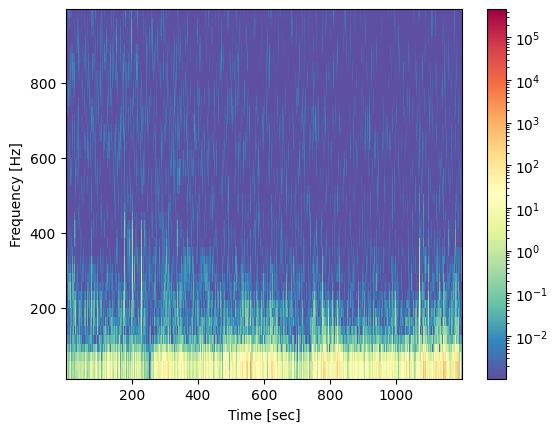

In [33]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

In [ ]:
#Define time and frequency limits
time_start, time_end = 891, 897  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

In [ ]:
#Define time and frequency limits
time_start, time_end = 892.5, 893.2  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

**Save HERE !!!!!**